# South-building

## functions

In [1]:
import sys,os
sys.path.append('python-code')
from utils import *
from init_camera import initialize
from register_camera import register
import seaborn as sns

## load data 

In [6]:
def init():
    ################################################
    # initialize configuration and camera dictionary
    ################################################
    K=np.array([[2559.68,0,1536],[0,2559.68,1152],[0,0,1]])
    DISTCOEFFS=np.array([-0.0204997,0,0,0])
    
    DIR_IMAGES='Images/south_building/*.JPG'
    config=SFM_Params(DIR_IMAGES,n_images=50,hessianThreshold=1000,detector='SIFT',matcher='FLANN')
    dict_cameras={}
    n_cameras=config.n_cameras
    for i in range(n_cameras):
        dict_cameras[i]={}
    
    config.K=K
    config.DISTCOEFFS=DISTCOEFFS.astype('float32')
    
    config.ratio_test_threshold=0.65
    config.pnp_threshold = 5
    config.dist_threshold=200
    config.post_threshold= 5
    config.pre_threshold=12
    config.indice_registered_cameras=[]
    
    return config,dict_cameras

Loaded in total 50 frames 
Feature detection takes 71 seconds
Feature matching takes 4779 seconds
`ftol` termination condition is satisfied.
Function evaluations 26, initial cost 4.5354e+04, final cost 1.1805e+03, first-order optimality 3.43e+01.
Use camera 46 and camera 47 to initialize, 29989 pairs used, 27461 pairs reconstructed 
---------------------------------------------------------------------------------------
Registering 3th camera............
Use 14702 out of 14863 points to register camera 45 by camera 46
`ftol` termination condition is satisfied.
Function evaluations 129, initial cost 6.4440e+04, final cost 3.3001e+03, first-order optimality 1.16e+03.
115433 observations, 48358 3D points
---------------------------------------------------------------------------------------
Registering 4th camera............
Use 18367 out of 19081 points to register camera 44 by camera 45
`ftol` termination condition is satisfied.
Function evaluations 63, initial cost 5.9265e+04, final cos

MemoryError: Unable to allocate array with shape (23468472,) and data type float64

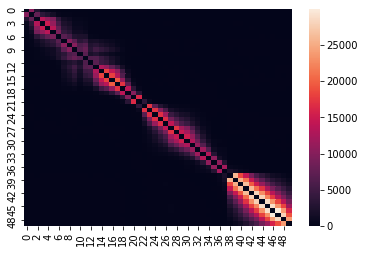

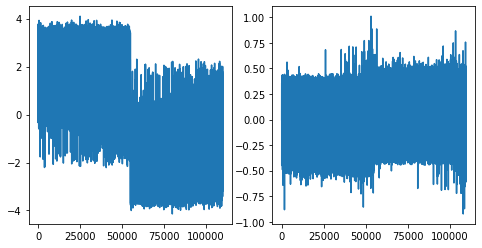

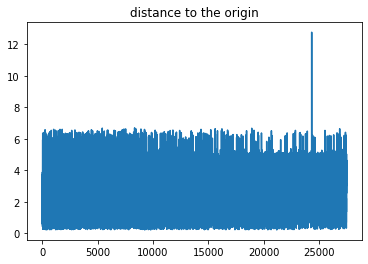

In [7]:
SAVE_NAME='south_building'
if(not os.path.exists('results/%s' % SAVE_NAME)):
    os.makedirs('results/%s' % SAVE_NAME)
########################################################
# init configurations 
########################################################
config,dict_cameras=init()



########################################################
# load images
########################################################
dict_cameras=load_images(config,dict_cameras)



########################################################
# extract features
########################################################
dict_cameras=extract_features(config,dict_cameras)



########################################################
# match features
########################################################
dict_cameras=match_features(config,dict_cameras)
ax = sns.heatmap(config.n_good_matches)



########################################################
# initialize the first two images
########################################################
config,dict_cameras=initialize(config,dict_cameras)
np.savetxt('results/%s/2.txt' % SAVE_NAME,config.reconstructed_points_3d,delimiter=';')



########################################################
# register more cameras
########################################################
n_cameras=config.n_cameras
for i in range(n_cameras-2):
    print('---------------------------------------------------------------------------------------')
    print('Registering %dth camera............' % (i+3))
    config,dict_cameras,n_observations,n_points_3d=register(config,dict_cameras)
    print('%d observations, %d 3D points' %(n_observations,n_points_3d))

    mask=[]
    for crn_camera_index in config.indice_registered_cameras:
        mask.extend(dict_cameras[crn_camera_index]['point_indice'].tolist())
    mask=list(set(mask))
    reconstructed_points_3d=config.reconstructed_points_3d[mask]
    np.savetxt('results/%s/%d.txt' % (SAVE_NAME,i+3),reconstructed_points_3d,delimiter=';')

In [8]:
config.reconstructed_points_3d.shape

(372879, 3)

In [14]:
len(config.indice_registered_cameras)

40

In [16]:
from bundle_adjustment import fun
n_cameras=len(config.indice_registered_cameras)
n_points=config.reconstructed_points_3d.shape[0]

# points_3d, n_points x 3
points_3d=config.reconstructed_points_3d

# get camera params,points_2d, camera_indice
camera_params=np.zeros((n_cameras,6))
camera_indices=[]
point_indices=[]
points_2d=[]
for j in range(n_cameras):
    crn_camera_index=config.indice_registered_cameras[j]

    camera_params[j,:]=dict_cameras[crn_camera_index]['camera']
    camera_indices.extend([j]*dict_cameras[crn_camera_index]['indice_registered_2d'].shape[0])
    point_indices.extend(dict_cameras[crn_camera_index]['point_indice'].tolist())

    for ele in dict_cameras[crn_camera_index]['indice_registered_2d']:
        points_2d.append(dict_cameras[crn_camera_index]['kp'][ele].pt)

points_2d=np.float64(points_2d)
camera_indices=np.array(camera_indices)  
point_indices=np.array(point_indices)  

# calibrate the 2d image pts to calculate residual
if(points_2d.shape[1]==2):
    points_2d=np.hstack((points_2d,np.ones((points_2d.shape[0],1))))
points_2d=np.dot(np.linalg.inv(config.K),points_2d.T).T
points_2d=points_2d[:,:2]

# optimize
x0 = np.hstack((camera_params.ravel(), points_3d.ravel()))
f0=fun(x0,n_cameras, n_points, camera_indices, point_indices, points_2d,config.K)

In [18]:
f0.mean()

0.009773443144961327